In [1]:
from IPython.display import Image, display

from typing import Any, Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

import operator

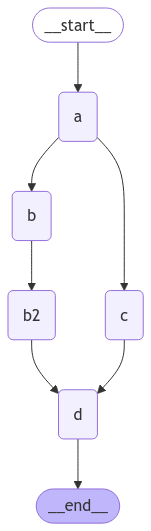

In [2]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list """
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)


class State(TypedDict):
    state: Annotated[list, sorting_reducer]

class ReturnNodeValue:
    def __init__(self, node_secret:str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I am A"))
builder.add_node("b", ReturnNodeValue("I am B"))
builder.add_node("b2", ReturnNodeValue("I am B2"))
builder.add_node("c", ReturnNodeValue("I am C"))
builder.add_node("d", ReturnNodeValue("I am D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("b2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I am A to []
Adding I am B to ['I am A']
Adding I am C to ['I am A']
Adding I am B2 to ['I am A', 'I am B', 'I am C']
Adding I am D to ['I am A', 'I am B', 'I am C']
Adding I am D to ['I am A', 'I am B', 'I am B2', 'I am C', 'I am D']


# Working with LLMs

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

In [5]:
llm = ChatOpenAI(model="gpt-4o")

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

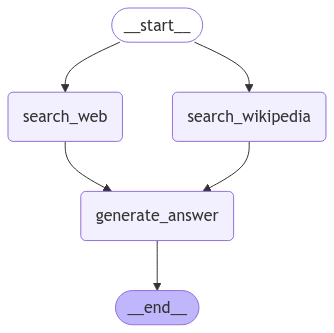

In [ ]:
def search_web(state):
    """ Retrieve docs from web search """

    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):
    """ Retrieve docs from wikipedia """
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):
    """ Node to answer a question """

    context = state["context"]
    question = state["question"]

    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    return {"answer": answer}

builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
result = graph.invoke({"question": "How were AMD's Q2 2024 earnings?"})
result['answer'].content

"AMD's Q2 2024 earnings were strong, with non-GAAP earnings of $0.69 per share, which beat the Zacks Consensus Estimate by 2.99% and represented a 19% increase year over year. The company reported revenues of $5.8 billion. On a non-GAAP basis, AMD had a gross margin of 53%, operating income of $1.3 billion, and net income of $1.1 billion. On a reported basis, net income was $265 million, with diluted earnings per share of $0.16."